# How To: Use a combinations matrix to keep track of combinabilities

## Preparations

In [1]:
# Set up the path to SModelS installation folder
import sys; sys.path.append("."); import smodels_paths

In [2]:
# Import those parts of smodels that are needed for this exercise
from smodels.tools.physicsUnits import GeV
from smodels.experiment.databaseObj import Database
from smodels.theory.theoryPrediction import theoryPredictionsFor, TheoryPredictionsCombiner
from smodels.theory import decomposer
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model

In [15]:
# a combinations matrix is just a dictionary with combinable analyses as both keys and values.
# we assume "commutativity"! (if A is combinable with B, then B is combinable with A)
combinationsmatrix = { "CMS-SUS-21-002": [ "CMS-SUS-19-006-agg", "CMS-EXO-19-006"]} 
# also define a list of analyses we are interested in
analyses = [ "CMS-SUS-21-002", "CMS-SUS-19-006-agg", "CMS-SUS-20-004"]

here is a visualisation of the combinations matrix (dropping the -agg suffix):

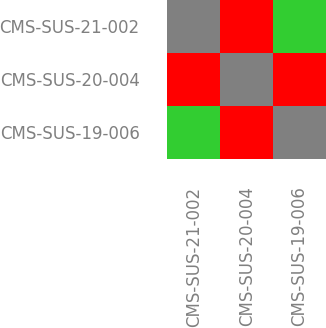

In [13]:
## Load the official database:
db = Database("https://smodels.github.io/database/official230", combinationsmatrix=combinationsmatrix)
results = db.getExpResults(analysisIDs=analyses, dataTypes = [ "efficiencyMap"])
print ( f"we have selected {len(results)} results" )

we have selected 3 results


In [5]:
# the theory we will be using
inputFile = "inputFiles/slha/gluino_squarks.slha"

In [6]:
# prepare the model
model = Model(BSMparticles=BSMList, SMparticles=SMList)
model.updateParticles(inputFile=inputFile)
# obtain the decomposed model
toplist = decomposer.decompose(model)

## run SModelS

In [7]:
# get the predictions
predictions = list ( theoryPredictionsFor(results, toplist, combinedResults=False ) )

In [8]:
# let's have a quick look at the predictions, and the (expected) r-values
[ (x.dataset.globalInfo.id, round(x.getRValue(expected=True),3)) for x in predictions ]

[('CMS-SUS-19-006-agg', 1.229),
 ('CMS-SUS-20-004', 0.002),
 ('CMS-SUS-21-002', 0.077)]

In [9]:
for i,pr1 in enumerate(predictions[:-1]):
    id1 = pr1.dataset.globalInfo.id
    for pr2 in predictions[i+1:]:
        id2 = pr2.dataset.globalInfo.id
        combinable = pr1.dataset.isCombinableWith(pr2.dataset)
        print ( f"can I combine {id1} with {id2}? {'yes' if combinable else 'no'}" )

can I combine CMS-SUS-19-006-agg with CMS-SUS-20-004? no
can I combine CMS-SUS-19-006-agg with CMS-SUS-21-002? yes
can I combine CMS-SUS-20-004 with CMS-SUS-21-002? no


In [10]:
# lets make a dictionary with the analysis ids as keys
d = { x.dataset.globalInfo.id:x for x in predictions }

## combine!

In [11]:
# we are allowed to combine CMS-SUS-19-006 with CMS-SUS-21-002
combiner = TheoryPredictionsCombiner ( [ d[x] for x in ( "CMS-SUS-19-006-agg", "CMS-SUS-21-002")])

In [12]:
# the combined expected r value must be above the individual expected r-values
round(combiner.getRValue(expected=True),3)

1.242